##  Home Prices Prediction using Decision Tress

In this analysis, we seek to develop a high reliability model to predict housing prices. We find that while the decision trees provide a very good prediction for the housing prices, the Ridge Regression analysis developed previously was superior to the decision tree models we used.

A quick look at the data indicates that the data set has 80 variables which can be used in a predictive model. Of these 80 variables, 38 appear to be quantitative and the rest are categorical variables. A deeper look identifies that 3 numeric variables are actually categorical, putting the count at 35 quantitative and 45 categorical.

A look at the sales price distribution shows that sales price is not normally distributed, having a long tail. In the research design and modelling methods section, we show that we can normalize the distribution with the application of a log transformation.

Looking at the quantitative variables, we identify that 19 variables contain null values, with 4 of them (Fence; Alley; MiscFeature; and PoolQC) being blank. For MiscFeature and PoolQC, we take this to mean that these mean that the house feature does not exist. We identifed that Fence and Alley had too many missing records to be useful and dropped these variables. We also found that Garage Area and number of cars were very strongly correlated so we removed the GarageArea, which had a lower correlation to SalePrice. The same applies to the year the house was built and the year the garage was built, and in this case removed GarageYrBlt. The EDA also identifies that the quantitative variables are not normally distributed and we log transformed the most highly skewed of these to attempt to normalize the distribution. Finally, a new quantitative variable was added: "AgeAtSale" which show the strongest negative correlation of all variables. This makes sense: people tend to pay more for newer houses.

To build a predictive model, we used 4 decision tree regression approaches
1) Random Forest Regressor
2) Decision Tree Regressor
3) Gradient Boosted Regression Trees
4) Gradient Boosted Regression Trees with Optimized number of trees

Of these, the Gradient Boosting Regressor stood out as the best predictor of the housing prices. This was surprising as the hypothesis was that the code to generate the optimized number of trees would provide us with a superior result.

We tested our predictive model results in Kaggle and generated a result of 0.14133, below the score achieved by the ridge regression model..

Given more time to expand the analysis, we would have added the following further steps:
1) Run different scalers on quantitative variables, not just log transform, to see if a better result can be generated.
2) Look at categorical variables, can we group them before creating dummy variables.
3) Run the analysis with fewer high correlation variables to see if we can generate a better predictor

At this time, we propose using to either continue using the previously developed ridge regressor model or to use the gradient boosted regression tree model and ensure that the sale price and quantitative variables are all log transformed.

In [51]:
RANDOM_SEED=1234

# Step 0 Import packages

#Basic dataframe, array, and math stuff
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport as pp

#Basic Operating System Stuff
import os
import gc #garbage collector
import random #random seed generator
import pandas_profiling # requires import and prior install 

#Timer
from timeit import default_timer as timer #import a timer

#Basic dataframe, array, and math stuff
import pandas as pd #data frame
import math #math functions
import numpy as np    #numerical package
from math import sqrt
import itertools
import xgboost as xgb
import lightgbm as lgb
# from imblearn.over_sampling import SMOTE #synthetic minority oversampling technique



#Scikit learn
import sklearn as sk  #scikit learn
 
from sklearn import tree
from sklearn import preprocessing    

from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet # Regression modeling package
from sklearn.linear_model import LogisticRegression as logreg # Classification modeling package
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier,SGDRegressor
from sklearn.linear_model import  RidgeCV, ElasticNet, LassoCV, LassoLarsCV # complex models found on net

from sklearn.ensemble import RandomForestRegressor # Random Forest package
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesRegressor # Extra Trees package
from sklearn.ensemble import GradientBoostingRegressor # Gradient Boosting package
from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import confusion_matrix #for 2-class model
from sklearn.metrics import roc_curve #for 2-class model
from sklearn.metrics import mean_squared_error, r2_score # evaluation metrics
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split as tts #train test split
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler # used for variable scaling data
from sklearn.preprocessing import MinMaxScaler as Scaler # used for variable scaling data
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

from sklearn.impute import SimpleImputer
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample #sampling
from sklearn.decomposition import PCA #principal components
from sklearn.naive_bayes import GaussianNB # Classification modeling package

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC


from scipy import misc #Lots of stuff here
from scipy import stats as st
from scipy.stats import skew 
from scipy.stats import pearsonr


#Graphing
import altair as alt
import seaborn as sns
import pydot  #For model plotting
from IPython.display import SVG #For model plotting
from IPython.display import display #For model plotting
import matplotlib.pyplot as plt #plotting
import matplotlib as mpl #image save
from matplotlib import pyplot as plt
from matplotlib import cm as cm
from matplotlib.pyplot import imshow #Show images
from PIL import Image #Another image utility

%matplotlib inline

# Set rows and columnns for display so that we can see more than just 10 rows from print
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)

# Set seaborn charts to seaborn default settings
sns.set()

In [52]:
# Read the data
train = pd.read_csv('../kagglehousing/train.csv')
test = pd.read_csv('../kagglehousing/test.csv')

## 2. Exploratory Data Analysis

The EDA starts with an overview of the data which points to 81 variables and 1460 rows of data. Of the 81 variables, 38 are quantitative and 43 are qualitative. 19 of the variables are missing values.

We start by looking at the saleprice data. We see that the distribution is not normal, and this will require some form of transformation. We see that the log normal curve fits the sales price distribution quite well, so we will use the log normal transformation on the sales price when doing the modeling.

In the first step of the quantitative analysis we identify that MSSubClass, OVerallQual and OVerallCond are actually categorical variables with numerical values, and will have to be converted to categorial data in the transformation.

none of the quantitative variables have a normal distribution, which means they will have to undergo some form of transformation.

 

We then identify that of the quantitative measures, OverallQual (0.790982), GrLivArea (0.708624), GarageCars (0.640409), GarageArea (0.623431), TotalBsmtSF (0.613581), 1stFlrSF (0.605852), FullBath (0.560664), TotRmsAbvGrd (0.533723) and YearBuilt (0.522897) all have high correlations to sale price, and would be good predictors to use.

In the next 3 cells look at correlation between the quantitative measures.
We first look at the correlation matrix. It large and messy, hard to gain any insight from, so we create a graphic correlation matrix in 2 ways. The first show color and darkness to indicate positive and negative and intensity. The second shows level of correlation by size.

The following stands out:
Year Built and Year Garage Built are very highly correlated, and it is likely that these variables are not mutually exclusive (garge mos tlikely built when house was built)
The varaibles related to basement all appear to be closely related, though the correlation matrix shows the number to be lower than the chart suggests (probalby an optical iullsion from all these measures being close to each other)

Seeing that there are significant potential correlations, we generate a list of variables with high correlations and identify the following that stand out: 
GarageArea & GarageCars (0.88), 
GarageYrBlt & YearBuilt (0.83), 
GrLivArea & TotRmsAbvGrd (0.83), 
1stFlrSF & TotalBsmtSF (0.82)

This suggests that we can drop GarageCars and GarageYrBlt as variables. The bigger the garage the more cars it can hold and the grage is most likely built in the same year as the house.
Logic suggests that livable area will correspond with rooms (more area, more rooms) so we will leave this variable.
It makes sense that Basement quare footage will correlate with 1st floor as the masemet level is right below the first floor, so we will leave this.

Reviewing the qualitative data, we see that most of the qualitative variables have significant outliers when compared with the sale price. We have to take this into consideration when building the models, and we would benefit from regression models which would reduce the impact of far outliers. 


### Load data take preliminary Look

Interesting that training data and test data are the same size, not 80-20 split that we normally see

1460 rows of data, 81 columns.

Need to see whats in the type of variables next

In [53]:
# This generates the list of whats in the data set. 

train.shape, test.shape

((1460, 81), (1459, 80))

In [54]:
# Review train headings
# Looks like a lot of variables of different types. We need to get a breakdown

display(train.head())

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Create a copy of data to avoid accidentally modifying orginal data and set ID to the Index

For EDA we will use df as the dataframe. It will be a copy of train.csv

In [55]:
# Create a copy of data to avoid accidentally modifying orginal data and set ID to the Index


df = train.copy()
df.set_index('Id', inplace=True)
display(df.head())

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Review train headings and generate a list of variables

Looks like a lot of variables of different types.

Total 81 columns. List shows data types of each column.

In [56]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

None

### Review Target distribution

Data is skweded to left when comparing against a normal distribution.

We have a closer fit with log normal curve. We will have to take log of Y sale price when running classification exercise.

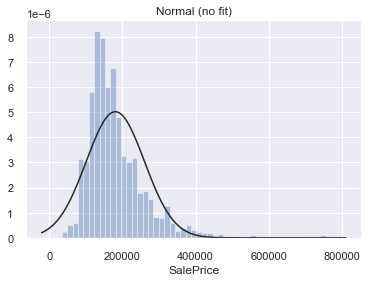

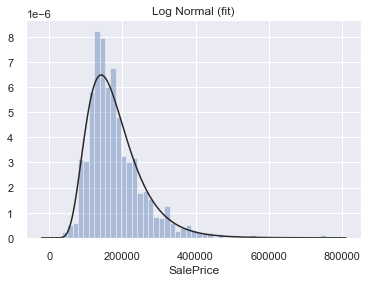

In [57]:
# Look at distribution of sale price. 
# We do not have a normal distribution

import scipy.stats as st
y = train['SalePrice']
plt.figure(2); plt.title('Normal (no fit)')
sns.distplot(y, kde=False, fit=st.norm)
plt.figure(3); plt.title('Log Normal (fit)')
sns.distplot(y, kde=False, fit=st.lognorm)

### Analyze quantitiative variables

37 quantitative variables

In [58]:
# Seperate and count quantitative variables
# 37 of the variables are quantitative

quant_variables = df.select_dtypes(include = [np.number])
#quant_variables.columns.tolist()

df_quant=pd.DataFrame(quant_variables)
df_quant_type = df_quant.dtypes

print('Quantitative variables and type:')
display(df_quant_type)

df_quant_type.nunique()
print('Number of quantitative variables:',len(df_quant_type))

Quantitative variables and type:


MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice          int64
dtype: object

Number of quantitative variables: 37


### Review Quantitative Data first 5 rows

Looks like MSSubClass, OverallQual and OverallCond are not continuous quantitative variables but actually numerical codings of categorical data. We convert these into categorical data.

In [59]:
df.select_dtypes('number').head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500
2,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500
3,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500
4,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,140000
5,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,250000


In [60]:
# Convert categorical columns into categorical data fields

df['MSSubClass'] = pd.Categorical(df.MSSubClass)
df['OverallQual'] = pd.Categorical(df.OverallQual)
df['OverallCond'] = pd.Categorical(df.OverallCond)

#Rebuild quant_variables to relect change in category for subseqeunt analyses
quant_variables = df.select_dtypes(include = [np.number])
df_quant=pd.DataFrame(quant_variables)

# Print list of converted columns to confirm data change
df_convert=pd.DataFrame(df,columns=['MSSubClass', 'OverallQual', 'OverallCond'])
print (df_convert.dtypes)

MSSubClass     category
OverallQual    category
OverallCond    category
dtype: object


### Look for missing values in quantitative data

In the quantitative data, 3 fields are missing data. Lot Frontage, GarageYrBlt and MasVnrArea.

We will impute this data with the average data.

LotFrontage    259
GarageYrBlt     81
MasVnrArea       8
dtype: int64

Number of variables missing data: 3


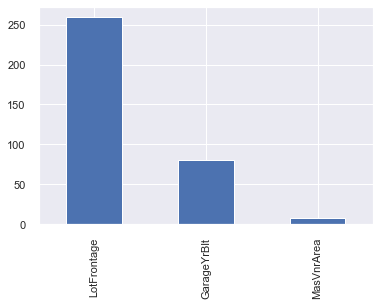

In [61]:
# Look for missing values

missing = df_quant.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True,ascending=False)
display(missing)
missing.plot.bar()

df_missing=pd.DataFrame(missing)
df_missing.nunique()
print('Number of variables missing data:',len(df_missing))

train = pd.read_csv('../kagglehousing/train.csv')

### Check for normal distribution in Quantitative data

We check the quantitative data to see if any of the quantitative data has a normal distribution.
The first check using  the Shapiro-Wilk test suggests that none of the quantitative feautuers have a normal distuibution.

In [62]:
# Check if any of the quantitative features have a normal distribution
# scipy.stats.shapiro performs the Shapiro-Wilk test for normality.
# The script below first segregates out all the quantitative values by looking for items not objects
# After that it runs the test for normality
# If the result is "True" some of the quantitative features are normally distributed
#In the case the formula returns "False" indicating non of the quantitative features are normally distributed

from scipy import stats

quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(train[quantitative])
normal = normal.apply(test_normality)
print(not normal.any())

False


We then look at the historgrams to see what tranformation would help with the variables. 

It appears that many variables are highly skewed to the left or right.

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matpl

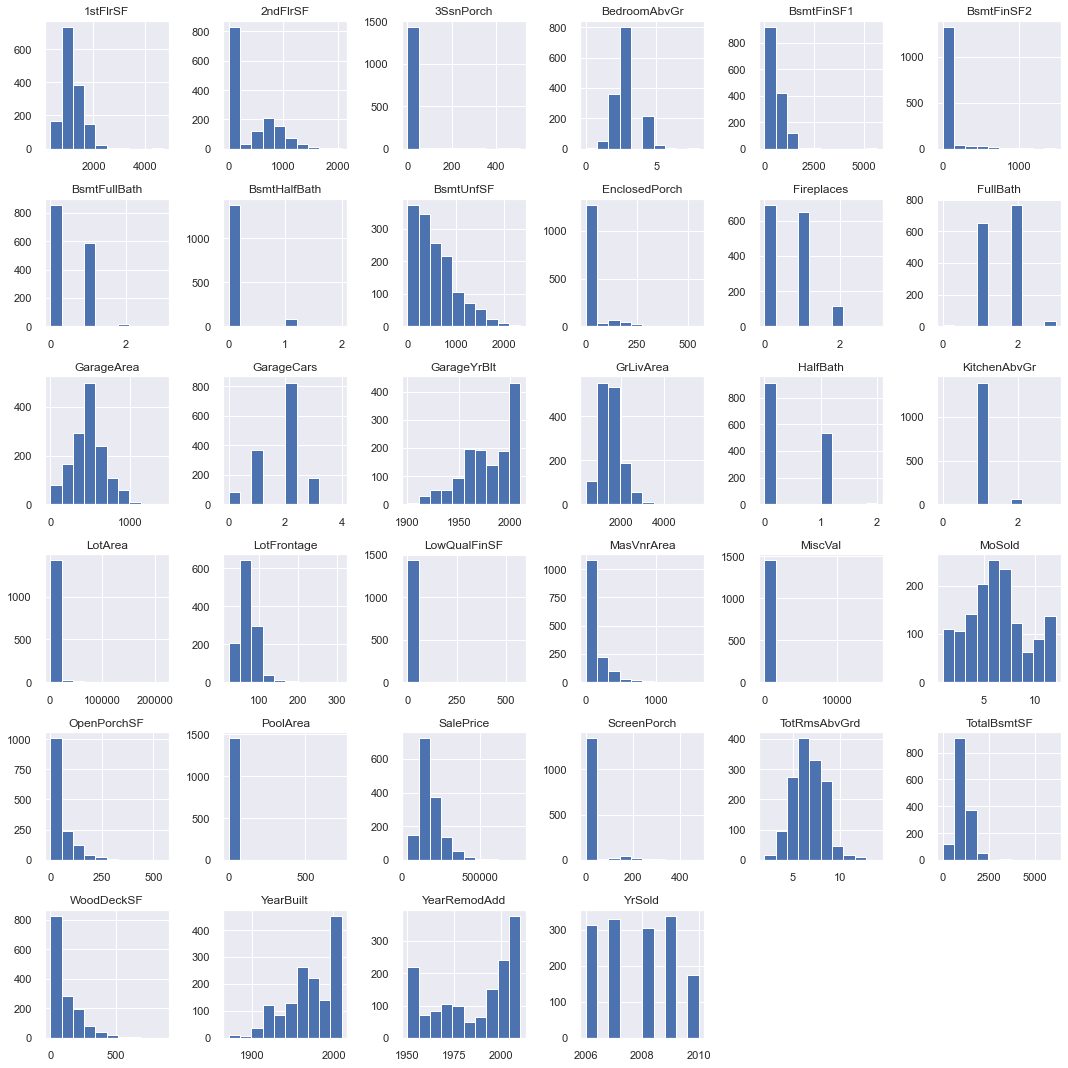

In [63]:
# The independent variables distribution
df_quant.hist(figsize=(15, 15))
plt.tight_layout()


### Quantitative variables correlation to sale price
Data indicates that the strongest indicators of sale price are OverallQual, GrLivArea, GarageCars and GarageArea have the highest correlation to sale price.

In [64]:
# Identify which variables have higher correlation to sale price
# Make sure to sort list by correlation
# Strong predictors are overall quality, Gross livable Area, Garage Capacity, Garage Area, Basement size and 1st Floor size
# Overall 10 decent correlation variables:
# OverallQual ,GrLivArea ,GarageCars,GarageArea ,TotalBsmtSF, 1stFlrSF ,FullBath,TotRmsAbvGrd,YearBuilt, YearRemodAdd 

corr=df_quant.corr()["SalePrice"]
corr[np.argsort(corr, axis=0)[::-1]]

SalePrice        1.000000
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

### Correlation of quant variables

The next step is to see if any of the quantitative variables have strong correlations to each other

In the next 3 cells look at correlation between the quantitative measures.
We first look at the correlation matrix. It large and messy, hard to gain any insight from, so we create a graphic correlation matrix in 2 ways. The first show color and darkness to indicate positive and negative and intensity. The second shows level of correlation by size.

The following stands out:
Year Built and Year Garage Built are very highly correlated, and it is likely that these variables are not mutually exclusive (garge mos tlikely built when house was built)
The varaibles related to basement all appear to be closely related, though the correlation matrix shows the number to be lower than the chart suggests (probalby an optical iullsion from all these measures being close to each other)

Seeing that there are significant potential correlations, we generate a list of high collinearity variables. The following stand out: GarageArea & GarageCars (0.882475), GarageYrBlt & YearBuilt (0.83), GrLivArea & TotRmsAbvGrd (0.83) 1stFlrSF & TotalBsmtSF (0.82). We will remove GarageArea and GarageYrBlt as these look redundant. The other high correlation pairs contain data that is useful.

In [65]:

corr = quant_variables.corr()
corr.style.background_gradient(cmap='RdBu_r')
#Choose from cmap: 'coolwarm' or  'RdBu_r' & 'BrBG' 

### Identify Collinear Variables
4 highly collinear pairs (>80% correlation, we will remove one of the collinear pairs in the analysis.)

In [66]:
# identify Collinear variables

correlations=train.corr()
attrs = correlations.iloc[:-1,:-1] # all except target

threshold = 0.5
important_corrs = (attrs[abs(attrs) > threshold][attrs != 1.0]) \
    .unstack().dropna().to_dict()

unique_important_corrs = pd.DataFrame(
    list(set([(tuple(sorted(key)), important_corrs[key]) \
    for key in important_corrs])), 
        columns=['Attribute Pair', 'Correlation'])

unique_important_corrs_list=unique_important_corrs.sort_values(by=['Correlation'],  ascending=False)

display(unique_important_corrs_list)


,Attribute Pair,Correlation
18,"(GarageArea, GarageCars)",0.882475
0,"(GarageYrBlt, YearBuilt)",0.825667
12,"(GrLivArea, TotRmsAbvGrd)",0.825489
14,"(1stFlrSF, TotalBsmtSF)",0.819530
13,"(2ndFlrSF, GrLivArea)",0.687501
27,"(BedroomAbvGr, TotRmsAbvGrd)",0.676620
8,"(BsmtFinSF1, BsmtFullBath)",0.649212
25,"(GarageYrBlt, YearRemodAdd)",0.642277
9,"(FullBath, GrLivArea)",0.630012
5,"(2ndFlrSF, TotRmsAbvGrd)",0.616423


### Qualitative Variables Analysis

We now look at the quantitative variables. It appears that most of the quantitative variables are showing large numbers of outliers


### Count Number of Qualitative Variables

46 qualitative variables, including the 3 quantitative variables that were converted to categorical.

In [67]:
# Seperate and count qualitative variables
# 46 of the variables are quantitative

qual_variables = df.select_dtypes(exclude = [np.number])
qual_variables.columns.tolist()

df_qual=pd.DataFrame(qual_variables)
df_qual_type = df_qual.dtypes

print('Qualitative variables and type:')
display(df_qual_type)

df_qual_type.nunique()
print('Number of qualitative variables:',len(df_qual_type))

Qualitative variables and type:


MSSubClass       category
MSZoning           object
Street             object
Alley              object
LotShape           object
LandContour        object
Utilities          object
LotConfig          object
LandSlope          object
Neighborhood       object
Condition1         object
Condition2         object
BldgType           object
HouseStyle         object
OverallQual      category
OverallCond      category
RoofStyle          object
RoofMatl           object
Exterior1st        object
Exterior2nd        object
MasVnrType         object
ExterQual          object
ExterCond          object
Foundation         object
BsmtQual           object
BsmtCond           object
BsmtExposure       object
BsmtFinType1       object
BsmtFinType2       object
Heating            object
HeatingQC          object
CentralAir         object
Electrical         object
KitchenQual        object
Functional         object
FireplaceQu        object
GarageType         object
GarageFinish       object
GarageQual  

Number of qualitative variables: 46


### Look for missing values in qualitative data

Features like FireplaceQu (Number of fireplases?), Fence, Alley, MiscFeature and PoolQC are missing values.

A review of the CSV file shows the values as NA

Assume that for these, the missing value is a sign that the house does not have that feature

Fence and Alley are missing significant numbers of records, so we should drop these as it likely indicates no data for a high percent of the data.

PoolQC, Misc Feature & FireplaceQU is indicative of none, so we should fill with 0.

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
GarageCond        81
GarageQual        81
GarageFinish      81
GarageType        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrType         8
Electrical         1
dtype: int64

Number of variables missing data: 16


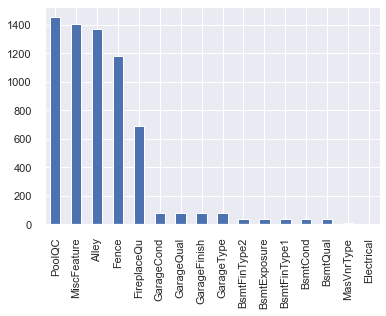

In [68]:
# Look for missing values

missing = df_qual.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True,ascending=False)
display(missing)
missing.plot.bar()

df_missing=pd.DataFrame(missing)
df_missing.nunique()
print('Number of variables missing data:',len(df_missing))

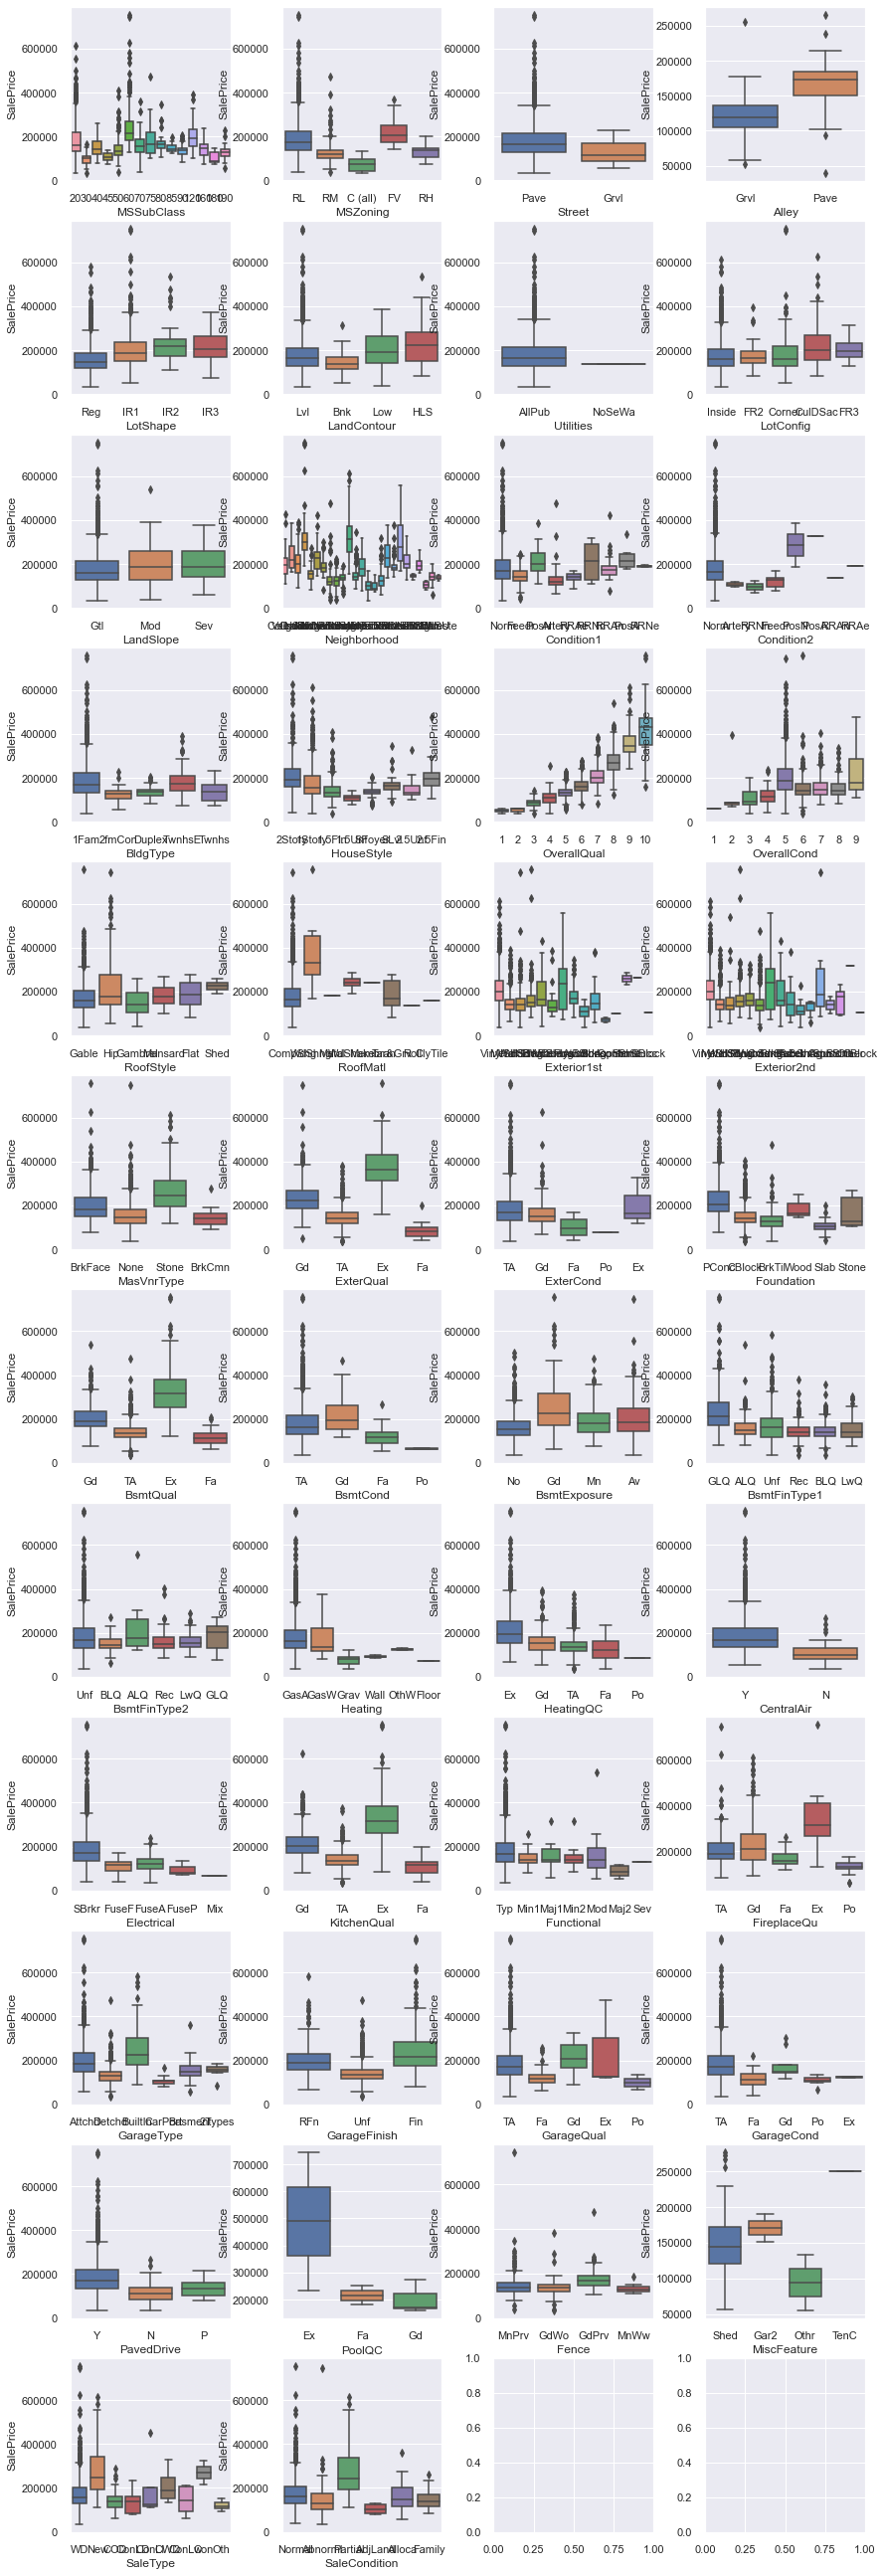

In [69]:
# Boxplot Qualitative Variables
# Box plot of qualitative variables - large number of outliers


# Check the independent variables (categorical) distributions
fig, axes = plt.subplots(12, 4, figsize=(12, 36))
fig.tight_layout()
axes = axes.reshape(-1)
# Plot
for i, col in enumerate(df_qual):
    ax=sns.boxplot(x=col, y='SalePrice', data=df, ax=axes[i])


## 3. Research Design and Modeling methods

The first step in research design is to look at the EDA results, determine what actions need to be taken and define a data approach.

The EDA deteremined that the distribution of sale price is not normal, so normalizing sale price is a key step.

The EDA identified 8 key quantitative variables which would be key in the model due to high correlation 

The next step is to determine which models would work best in modeling the transformed data.

In [70]:
# Designate Data as train for training, and then use the same code but designate test as the data for predicting
df = pd.read_csv('../kagglehousing/train.csv')

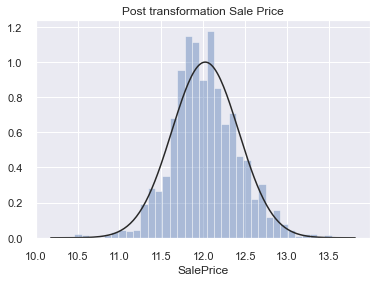

In [71]:
# Log transform sales price to normalize
# Use the numpy fuction log1p which  applies log(1+x) to all elements of the column
# Note that the distribution is now a normal distribution

df["SalePrice"] = np.log1p(df["SalePrice"])

y = df['SalePrice']
plt.figure(2); plt.title('Post transformation Sale Price')
sns.distplot(y, kde=False, fit=st.norm)

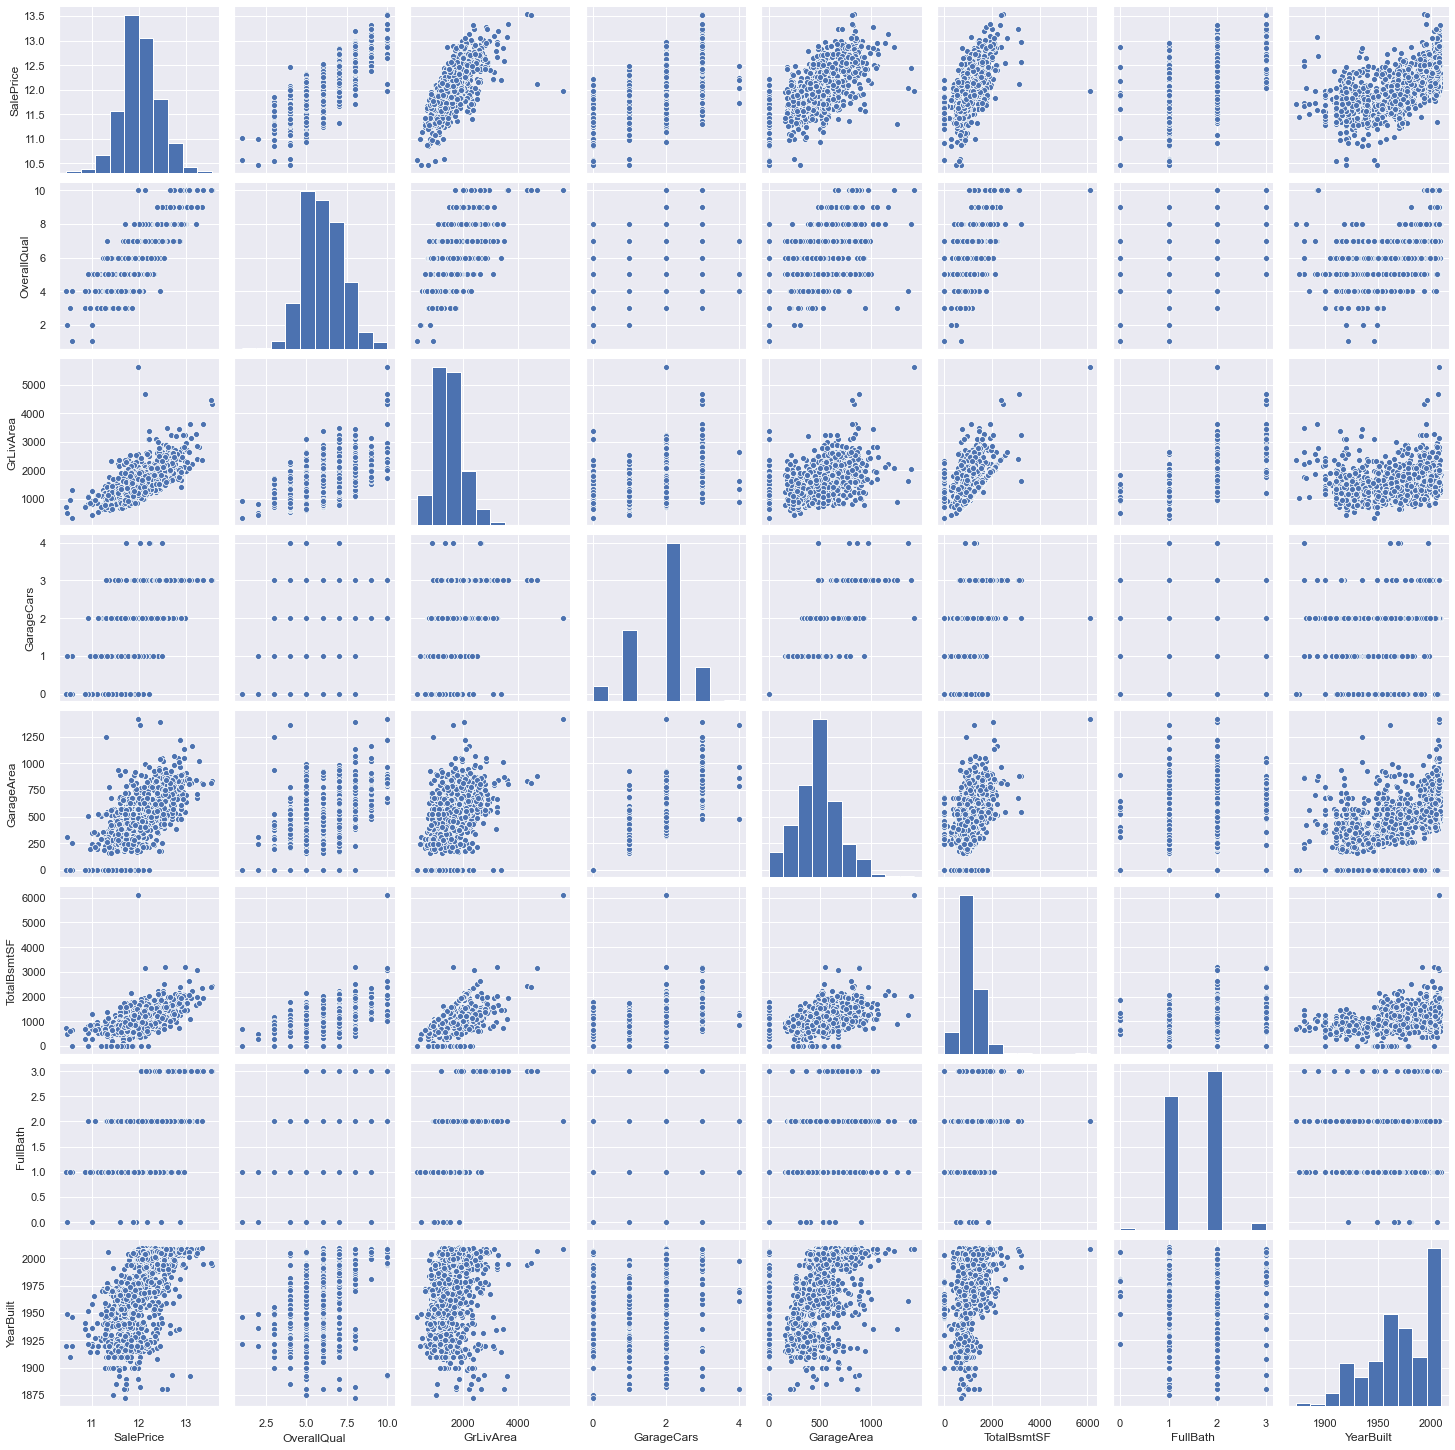

In [72]:
# Plot key quantitative variables aginst log transformed sale price
# We notice that the quantitative variables now line up better with Sale Price.

sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea','TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df[cols], height = 2.5)
plt.show();

### Check calculated variables to see if they have more correlation than base variables

In [73]:
# SaleAge: Year sold - Year built
# Age at sale has the higest negative correlation so should be added into data set

df["AgeAtSale"] = np.maximum(df["YrSold"] - df["YearBuilt"], 0)

corr=df.corr()["SalePrice"]
corr[np.argsort(corr, axis=0)[::-1]]

SalePrice        1.000000
OverallQual      0.817185
GrLivArea        0.700927
GarageCars       0.680625
GarageArea       0.650888
TotalBsmtSF      0.612134
1stFlrSF         0.596981
FullBath         0.594771
YearBuilt        0.586570
YearRemodAdd     0.565608
GarageYrBlt      0.541073
TotRmsAbvGrd     0.534422
Fireplaces       0.489450
MasVnrArea       0.430809
BsmtFinSF1       0.372023
LotFrontage      0.355879
WoodDeckSF       0.334135
OpenPorchSF      0.321053
2ndFlrSF         0.319300
HalfBath         0.313982
LotArea          0.257320
BsmtFullBath     0.236224
BsmtUnfSF        0.221985
BedroomAbvGr     0.209043
ScreenPorch      0.121208
PoolArea         0.069798
MoSold           0.057330
3SsnPorch        0.054900
BsmtFinSF2       0.004832
BsmtHalfBath    -0.005149
Id              -0.017942
MiscVal         -0.020021
OverallCond     -0.036868
YrSold          -0.037263
LowQualFinSF    -0.037963
MSSubClass      -0.073959
KitchenAbvGr    -0.147548
EnclosedPorch   -0.149050
AgeAtSale   

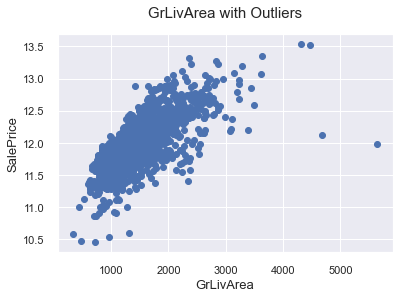

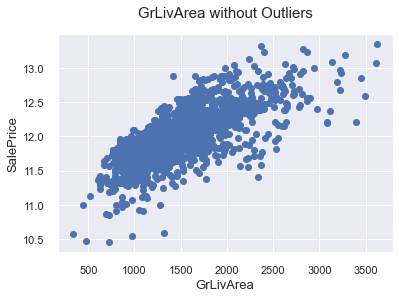

In [74]:
# Remove houses with GrLivArea > 4000
# The author says in documentation “I would recommend removing any houses with more than 4000 square feet from the data set"
# Scatter plot identifies 4 such data points

# Pre outlier removal
fig, ax = plt.subplots()
ax.scatter(x = df['GrLivArea'], y = df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.title('GrLivArea with Outliers', y=1.05, size=15)
plt.show()


# Deleting outliers
df = df.drop(df[(train['GrLivArea']>4000)].index)

# Review after outlier removal
fig, ax = plt.subplots()
ax.scatter(x = df['GrLivArea'], y = df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.title('GrLivArea without Outliers', y=1.05, size=15)
plt.show()


## 4. Conduct Analysis

The analysis was conducted in 4 steps.

Step 1 and 2 was to load the data and transform it. Data transformation started with applying a log transformation to sale price to normalize it, then quantitative variables were also log transformed to align with the sale price being log transformed. Step 3 was to generate the data matrices to feed the sklearn liner regression models.

In step 4 we ran the regressions. In this case we ran 4 random forest regressions using different models:

a) Random Forest Regressor

b) Decision Tree Regressor

c) Gradient Boosted Regression Trees

d) Gradient Boosted Regression Trees with Optimized number of trees


Running the trained models against test data, we find that the Gradient Boosted Regressor provided the best prediction but was still not superior to the regularized ridge regression.


### Step 1 Reload data in case EDA has modified the data

In [75]:
# Read the data
train = pd.read_csv('../kagglehousing2/train.csv')
test = pd.read_csv('../kagglehousing2/test.csv')


Remove Outlier data as per EDA and data author

In [76]:
train = train.drop(train[(train['GrLivArea']>4000)].index)


### Step 2 create a set of data that combines all the predictor features (X Values)

2a. Combine train and test data sets from MSubclass to Salecondition

In [77]:
# Transform all the predictor features
# This excludes the saleprice (which is after salecondition)

all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))



In [78]:
# Export data for review in Excel (not neccessary, just a test step to make sure 2a works)
all_data.to_csv('../kagglehousing2/alldata.csv')

2b. log transform sale price as sale price was identifed in EDA as  being skewed

In [79]:
# NOTE: This step transforms the SalePrice (Y value) in the TRAIN dataset not the ALL_DATA dataset
#
# We only do this for the Kaggle housing data because we identified that it is not normal distribution in the
#  "Look at distribution of sale price" of the EDA, and then identified take log transformation will make it
#  a normal distribution. If we identify that some other transformation would work better in EDA, we do that here.

train["SalePrice"] = np.log1p(train["SalePrice"])

2c. Remove unneccessary/non-useful columns and add in new data

Remove one of each variable in collinear pairs where logical

(GarageArea, GarageCars)	0.882475

(GarageYrBlt, YearBuilt)	0.825667

(GrLivArea, TotRmsAbvGrd)	0.825489

(1stFlrSF, TotalBsmtSF)     0.819530

In this case remove GarageArea, GarageYrBlt. Other pairs do not contain redundant data.

Remove Alley and Fence which have too many missing records

Add in AgeAtSale

In [80]:
all_data=all_data.drop(['GarageArea','GarageYrBlt','Alley','Fence'], axis=1,inplace=False, errors='raise')
df["AgeAtSale"] = np.maximum(df["YrSold"] - df["YearBuilt"], 0)
display(all_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2915 entries, 0 to 1458
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2915 non-null   int64  
 1   MSZoning       2911 non-null   object 
 2   LotFrontage    2429 non-null   float64
 3   LotArea        2915 non-null   int64  
 4   Street         2915 non-null   object 
 5   LotShape       2915 non-null   object 
 6   LandContour    2915 non-null   object 
 7   Utilities      2913 non-null   object 
 8   LotConfig      2915 non-null   object 
 9   LandSlope      2915 non-null   object 
 10  Neighborhood   2915 non-null   object 
 11  Condition1     2915 non-null   object 
 12  Condition2     2915 non-null   object 
 13  BldgType       2915 non-null   object 
 14  HouseStyle     2915 non-null   object 
 15  OverallQual    2915 non-null   int64  
 16  OverallCond    2915 non-null   int64  
 17  YearBuilt      2915 non-null   int64  
 18  YearRemo

None

2d. PoolQC, MiscFeature & FireplaceQU is indicative of none, so we should fill with 0

In [81]:
all_data['PoolQC'].fillna(0,inplace=True)
all_data['MiscFeature'].fillna(0,inplace=True)
all_data['FireplaceQu'].fillna(0,inplace=True)

2e. Convert categorical numerical columns into categorical columns

In [82]:
# This code converts the column from a quantitative date type into category
# This will ensure tha the data becomes a dummy field when we run the code for categorical data fields

all_data['MSSubClass'] = pd.Categorical(all_data.MSSubClass)
all_data['OverallQual'] = pd.Categorical(all_data.OverallQual)
all_data['OverallCond'] = pd.Categorical(all_data.OverallCond)

all_data_convert=pd.DataFrame(all_data,columns=['MSSubClass', 'OverallQual', 'OverallCond'])
print (all_data_convert.dtypes)

MSSubClass     category
OverallQual    category
OverallCond    category
dtype: object


2f. log transform skewed quantitative features

In [83]:
# EDA identified that many of the quantitative features did not have a normal distribution

numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #this line computes skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
skewed_feats = skewed_feats.drop('MSSubClass')

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

2g. Create dummy variables for categorical features

In [84]:
# get_dummies converts categorical variable into dummy/indicator variables.

all_data = pd.get_dummies(all_data)

2h. filling NA's with the mean of the column for quantitative data

In [85]:
all_data = all_data.fillna(all_data.mean())


### Step 3 Create data for Decision Trees

In [86]:
#3a Export tranformed data for review in Excel 
# Not neccessary, just a test step to review transformed data before creating matrices

all_data.to_csv('../kagglehousing2/alldata_transformed.csv')

In [87]:
#3b creating matrices for sklearn

X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y_train = train.SalePrice

X_train.to_csv('../kagglehousing2/X_train.csv')
X_test.to_csv('../kagglehousing2/X_test.csv')
y_train.to_csv('../kagglehousing2/y_train.csv')



### Step 4 Develop Random Forests and Gradient Boosted Regression Trees

### Random Forest Regressor
Model gives us a 98.33 R2 score and 0.15192 on Kaggle cross validation, which is not an improvement on the Ridge Regression

In [88]:
# This does a Random Forest Regressor and scores it.

random_forest = RandomForestRegressor(n_estimators=100)
random_forest.fit(X_train, y_train)
random_forest.score(X_train, y_train)
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)
print(acc_random_forest)


98.33


In [89]:
# Run Random Forest Regressor prediction on test data and submit to Kaggle for cross validation

random_forest_Pred_Log=(random_forest.predict(X_test))
random_forest_Pred=np.expm1(random_forest_Pred_Log)
display(random_forest_Pred_Log)
display(random_forest_Pred)

df_random_forest_Pred=pd.DataFrame(random_forest_Pred)
df_random_forest_Pred.to_csv('../kagglehousing2/random_forest_Pred.csv')

array([11.74201062, 11.92090502, 12.11842907, ..., 11.91933259,
       11.66911524, 12.35220121])

array([125743.91144701, 150376.64217515, 183216.46655735, ...,
       150140.36931726, 116903.80423578, 231467.99471503])

In [90]:
#df_LinReg_Pred=pd.DataFrame(LinReg_Pred)
#df_LinReg_Pred.to_csv('../kagglehousing/linRegPred.csv')

### Decision Tree Regressor
Model gives us a 97.61 R2 score and 0.21806 on Kaggle cross validation, which is not an improvement on the Ridge Regression.

In [91]:
# This does a Decision Tree Regressor and scores it.

tree_reg = DecisionTreeRegressor(max_depth=10)
tree_reg.fit(X_train, y_train)
tree_reg.score(X_train, y_train)
acc_tree_reg = round(tree_reg.score(X_train, y_train) * 100, 2)
print(acc_tree_reg)



97.61


In [92]:
# Run Decision Tree Regressor prediction on test data and submit to Kaggle for cross validation

tree_reg_Pred_Log=(tree_reg.predict(X_test))
tree_reg_Pred=np.expm1(tree_reg_Pred_Log)
display(tree_reg_Pred_Log)
display(tree_reg_Pred)

df_tree_reg_Pred=pd.DataFrame(tree_reg_Pred)
df_tree_reg_Pred.to_csv('../kagglehousing2/tree_reg_Pred.csv')

array([11.82743153, 11.87162877, 12.06966827, ..., 12.03118915,
       11.7301688 , 12.06966827])

array([136957.26604465, 143146.20297554, 174496.94896506, ...,
       167909.96554287, 124263.64466051, 174496.94896506])

### Gradient Boosted Regression Trees
Model gives us a 95.48 R2 score and  0.14133 on Kaggle cross validation, which is  the best of the random forest regressors but still not an improvement on the Ridge Regression.

In [93]:
GradientBoostingRegressor

# This does a Gradient Boosting Regressor and scores it.

gbrt = GradientBoostingRegressor()
gbrt.fit(X_train, y_train)
gbrt.score(X_train, y_train)
acc_gbrt = round(gbrt.score(X_train, y_train) * 100, 2)
print(acc_gbrt)


95.48


In [94]:
gbrt_Pred_Log=(gbrt.predict(X_test))
gbrt_Pred=np.expm1(gbrt_Pred_Log)
display(gbrt_Pred_Log)
display(gbrt_Pred)

df_gbrt_Pred=pd.DataFrame(gbrt_Pred)
df_gbrt_Pred.to_csv('../kagglehousing2/gbrt_Pred.csv')

array([11.68751412, 11.90942678, 12.16530908, ..., 11.90936658,
       11.75714082, 12.2918081 ])

array([119074.63039697, 148660.43952307, 192010.21782266, ...,
       148651.49060123, 127660.92318098, 217902.6130372 ])

### Gradient Boosted Regression Trees with Optimized number of trees

This uses the code in the text book to generate the optimal number of trees and trains another GBRT ensemble to the optimal number of trees. The optimal model is then used aginst the full data set.

Model gives us a 93.49 R2 score and 0.14461 on Kaggle cross validation, which is not an improvement on the Ridge Regression

In [95]:
train_X, val_X, train_y, val_y= train_test_split(X_train, y_train, random_state=1234)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(train_X, train_y)

errors=[mean_squared_error(val_y, pred_y)
        for pred_y in gbrt.staged_predict(val_X)]
bst_n_estimators=np.argmin(errors)


gbrt_best=GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(train_X,train_y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=119,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [96]:
gbrt2 = GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=119,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
gbrt2.fit(X_train, y_train)
gbrt2.score(X_train, y_train)
acc_gbrt2 = round(gbrt2.score(X_train, y_train) * 100, 2)
print(acc_gbrt2)

93.49


In [97]:
gbrt2_Pred_Log=(gbrt2.predict(X_test))
gbrt2_Pred=np.expm1(gbrt2_Pred_Log)
display(gbrt2_Pred_Log)
display(gbrt2_Pred)

df_gbrt2_Pred=pd.DataFrame(gbrt2_Pred)
df_gbrt2_Pred.to_csv('../kagglehousing2/gbrt2_Pred.csv')

array([11.70629259, 11.95690287, 12.15636498, ..., 11.97348045,
       11.76680103, 12.31866521])

array([121331.81586569, 155888.52617075, 190300.50829892, ...,
       158494.33715441, 128900.13921981, 223834.16878126])